# Импорт библиотек

In [1]:
!pip install transformers
!pip install datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from sklearn.model_selection import train_test_split

# Препроцессинг

## Разрешаем доступ

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загружаю датасет

In [4]:
file_path = "/content/drive/MyDrive/IMDB Dataset.csv"
df = pd.read_csv(file_path)
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})

## Проверка на баланс классов - все окей (50/50)

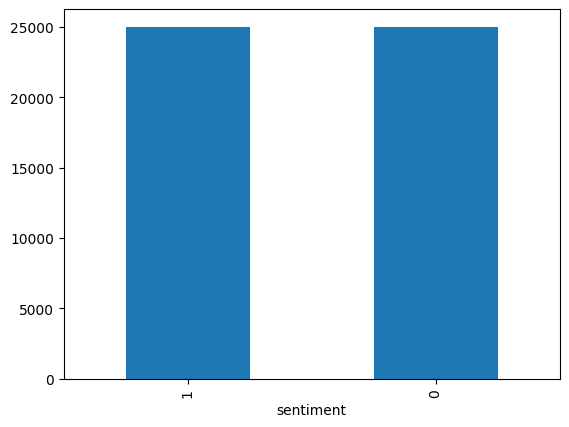

In [5]:
df.sentiment.value_counts().plot(kind = 'bar');

## Делю на трейн / валидацию /  тест

In [6]:
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42) #для сопоставимости резов внутри команды фиксируем 42 рандом сид и отрезаем 30 процентов на тест
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42) # теперь на трейне отрезаю тренировочный кусок и валидационный, пропорция 80/20
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 28000
Validation size: 7000
Test size: 15000


## Гружу предобученный токенайзер - как будто нет смысла в рамках этой работы писать свой, это вроде не основная цель

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Класс для работы с датасетом IMDB

In [8]:
class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        # принимаю фрейм с данными, токенизатор и максимальную длину последовательности
        self.data = dataframe.reset_index(drop=True)
        # сейвлю токенизатор для преобразования текста в токены
        self.tokenizer = tokenizer
        # запоминаю максимальную длину последовательности
        self.max_length = max_length

    def __len__(self):
        #  __len__ возвращает общее число примеров в фрейме
        return len(self.data)

    def __getitem__(self, idx):
        # __getitem__ позволяет получить конкретный пример по индексу

        # получаю текст отзыва по индексу
        review = self.data.iloc[idx]['review']
        # Получаю метку для этого отзыва - бинарнй таргет
        label = self.data.iloc[idx]['sentiment']

        # Токенизирую текст отзыва с помощью заданного выше предобученного токенизатора
        # padding паддинг до фиксированной длины
        # truncation : если текст длиннее макс длины, то он укорачивается
        # max_length: максимальная длина последовательности
        # return_tensors="pt": результат как торч тензор
        encoding = self.tokenizer(
            review,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # тк возвращаемые торч тензоры имеют размерность с дополнительным измерением,
        # я использую .squeeze(0), чтобы убрать это измерение и получить одномерные тензоры
        item = {key: tensor.squeeze(0) for key, tensor in encoding.items()}

        # + метка к моему словарю"labels", потому что сначала использовал импортнутый с библиотеки датасет и там
        # таргет назывался labels, поэтому немного костылей
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

## Подготавливаю датафрейм для передачи в нейронку

In [9]:
train_dataset = IMDBDataset(train_df, tokenizer)
val_dataset = IMDBDataset(val_df, tokenizer)
test_dataset = IMDBDataset(test_df, tokenizer)

## Создаю даталоадеры

In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Файн-тюнинг берта

In [11]:
# # Класс для обучения, валидации и теста
# # как будто нет смысла выбивать какие-то супер жесткие параметры которые дадут + 0.0000001% к аккураси, тк задача основная не в этом
# # поэтому особо параметры перебирать не буду, но потестирую, чтобы было валидно
class BERTImdb:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        device,
        learning_rate=3e-5,
        num_epochs=4,
        weight_decay=0.01,
        warmup_ratio=0.1,
        adam_epsilon=1e-8,
        max_grad_norm=1.0,
        attention_probs_dropout_prob=0.1,
        hidden_dropout_prob=0.1
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weight_decay = weight_decay
        self.adam_epsilon = adam_epsilon
        self.max_grad_norm = max_grad_norm
        self.model.config.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.model.config.hidden_dropout_prob = hidden_dropout_prob

        # AdamW
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay,
            eps=self.adam_epsilon  # используем eps
        )

        total_steps = len(self.train_loader) * self.num_epochs
        warmup_steps = int(total_steps * warmup_ratio)

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    def train_epoch(self):
        self.model.train()  # режим обучения
        total_loss = 0
        total_correct = 0
        total_examples = 0

        for batch in tqdm(self.train_loader, desc="Training"):
            self.optimizer.zero_grad()
            batch = {k: v.to(self.device) for k, v in batch.items()}
            outputs = self.model(**batch)
            loss = outputs.loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()

            # считаем accuracy на батче
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == batch["labels"]).sum().item()
            total_examples += batch["labels"].size(0)

        avg_loss = total_loss / len(self.train_loader)
        accuracy = total_correct / total_examples
        return avg_loss, accuracy

    def evaluate(self, data_loader):
        self.model.eval()  # режим оценки
        total_loss = 0
        total_correct = 0
        total_examples = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Evaluating"):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                outputs = self.model(**batch)
                loss = outputs.loss
                total_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch["labels"].cpu().numpy())

                total_correct += (preds == batch["labels"]).sum().item()
                total_examples += batch["labels"].size(0)

        avg_loss = total_loss / len(data_loader)
        accuracy = total_correct / total_examples
        return avg_loss, accuracy, all_preds, all_labels

    def train(self, early_stopping_patience=2):
        best_val_loss = float("inf")
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        epochs_without_improvement = 0

        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch + 1}/{self.num_epochs}")
            train_loss, train_acc = self.train_epoch()
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")

            val_loss, val_acc, _, _ = self.evaluate(self.val_loader)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

            # если лосс на валидации улучшился, сохраняем лучшую модель
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), "bert_best_model.pt")
                print("Saved best model.")
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                print(f"No improvement for {epochs_without_improvement} epoch(s).")
                if epochs_without_improvement >= early_stopping_patience:
                    print("Early stopping triggered.")
                    break

        # графики
        epochs_range = range(1, len(train_losses) + 1)
        plt.figure(figsize=(12, 5))

        # график лоса
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_losses, label="Train Loss")
        plt.plot(epochs_range, val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.legend()

        # аккураси
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_accs, label="Train Accuracy")
        plt.plot(epochs_range, val_accs, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Epoch")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def test(self):
        test_loss, test_acc, preds, labels = self.evaluate(self.test_loader)
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")
        return preds, labels

## Перевожу на gpu

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Предобученный берт

In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Создаю объект для обучения

In [14]:
bert_imdb = BERTImdb(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    learning_rate=2e-5,
    num_epochs=3,
    weight_decay=0.011,
    warmup_ratio=0.13
)

## обучение


Epoch 1/3


Training:   0%|          | 0/1750 [00:00<?, ?it/s]

Training loss: 0.2915, Training accuracy: 0.8767


Evaluating:   0%|          | 0/438 [00:00<?, ?it/s]

Validation loss: 0.1897, Validation accuracy: 0.9354
Saved best model.

Epoch 2/3


Training:   0%|          | 0/1750 [00:00<?, ?it/s]

Training loss: 0.1453, Training accuracy: 0.9564


Evaluating:   0%|          | 0/438 [00:00<?, ?it/s]

Validation loss: 0.2206, Validation accuracy: 0.9407
No improvement for 1 epoch(s).

Epoch 3/3


Training:   0%|          | 0/1750 [00:00<?, ?it/s]

Training loss: 0.0753, Training accuracy: 0.9820


Evaluating:   0%|          | 0/438 [00:00<?, ?it/s]

Validation loss: 0.2606, Validation accuracy: 0.9433
No improvement for 2 epoch(s).
Early stopping triggered.


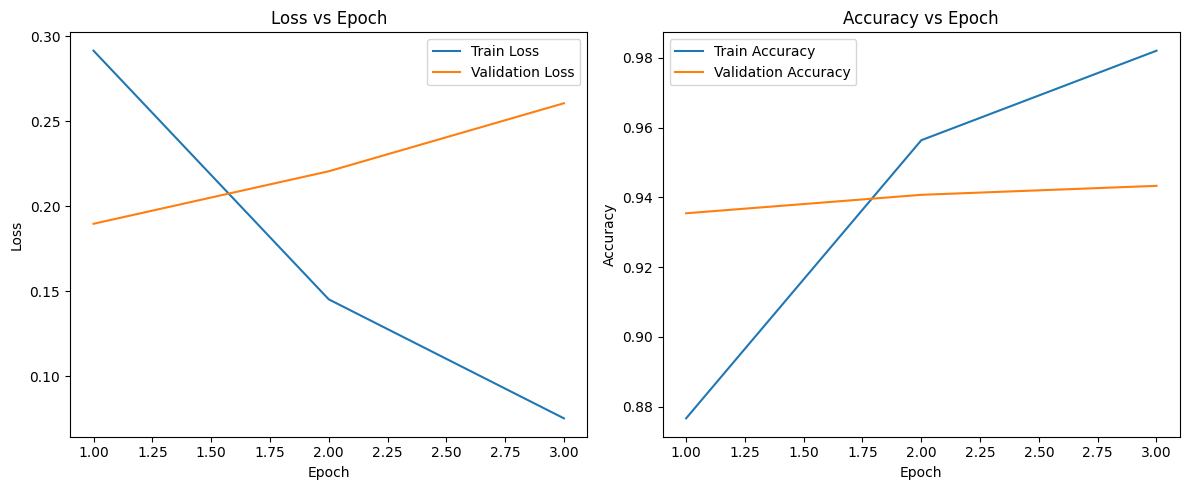

In [15]:
bert_imdb.train()

## считаем метрики на тесте

In [16]:
preds, labels = bert_imdb.test()

Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Test loss: 0.2714, Test accuracy: 0.9399


# Саммери
## - Да, обучил вроде неплохо, аккураси на тесте почти 94%, на трейне лосс падает, аккураси растет, но вот рост лосса на валидации меня супер смущает  - поиграюсь еще с параметрами...

In [ ]:
# !pip install nbstripout
# !nbstripout "/content/drive/MyDrive/Colab Notebooks/bert_fine_tune.ipynb"

In [18]:
model.load_state_dict(torch.load("bert_best_model.pt"))
model.save_pretrained("bert-imdb")
tokenizer.save_pretrained("bert-imdb")

('bert-imdb/tokenizer_config.json',
 'bert-imdb/special_tokens_map.json',
 'bert-imdb/vocab.txt',
 'bert-imdb/added_tokens.json')

# HF

In [19]:
!pip install huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineG

In [20]:
from huggingface_hub import HfApi, HfFolder, Repository, create_repo, upload_folder

In [21]:
create_repo("bert-imdb", private=False)

upload_folder(
    repo_id="AndreySerdyukov/bert-imdb",
    folder_path="bert-imdb",
    path_in_repo=".",
    commit_message="Добавлена модель после fine-tuning IMDB"
)

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AndreySerdyukov/bert-imdb/commit/79678c3fb67dbaff65bba99a733ebd4f5e35265e', commit_message='Добавлена модель после fine-tuning IMDB', commit_description='', oid='79678c3fb67dbaff65bba99a733ebd4f5e35265e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AndreySerdyukov/bert-imdb', endpoint='https://huggingface.co', repo_type='model', repo_id='AndreySerdyukov/bert-imdb'), pr_revision=None, pr_num=None)

In [22]:
model.load_state_dict(torch.load("bert_best_model.pt"))
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [25]:
tokenizer = BertTokenizer.from_pretrained("AndreySerdyukov/bert-imdb")
model = BertForSequenceClassification.from_pretrained("AndreySerdyukov/bert-imdb")

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]